<a href="https://colab.research.google.com/github/aziz-ayed/prostate_cancer/blob/main/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons==0.8.3

     |████████████████████████████████| 1.0 MB 11.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score

import pickle

import tensorflow as tf

from keras.layers import Flatten, Dense, Conv1D, Conv2D, AveragePooling1D, AveragePooling2D, MaxPooling1D, MaxPooling2D, Dropout, LSTM, TimeDistributed, Reshape, MaxPool2D, GRU, Normalization, Rescaling, Input, concatenate, BatchNormalization, GRU
from keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2, L1L2

from tensorflow.random import set_seed

#from tensorflow.keras.metrics import MeanAbsolutePercentageError, MeanSquaredError, mean_squared_error, mean_absolute_percentage_error
#import tensorflow_addons as tfa

from math import floor

import re

import os

import random

# Utils

In [ ]:
def filter_length(df, l):
    return df.groupby('EMPI').filter(lambda x : len(x)>l)

def random_split(df, split_ratio, l=3, seed=10, rate=True, report=True, comorb=True, race=True):
    
    permutation = np.random.RandomState(seed=seed).permutation(merged['EMPI'].unique())
    training_idx, test_idx = permutation[:floor(split_ratio*len(permutation))], permutation[floor(split_ratio*len(permutation)):]

    X_train, y_train = window(df[df['EMPI'].isin(training_idx)], l, rate=rate, report=report, comorb=comorb, race=race)
    X_test, y_test = window(df[df['EMPI'].isin(test_idx)], l, rate=rate, report=report, comorb=comorb, race=race)
    
    return X_train, y_train, X_test, y_test
  
def window(df, l, rate=True, report=True, comorb=True, race=True):
    
    df_x = pd.DataFrame()
    Y = []
    
    idx_comorb = df.columns.get_loc("mi_agg")
    comorb_names = df.columns[idx_comorb::]
        
    race_names = ["Asian", "Black", "Hispanic", "Unknown/other", "White"]
    
    iterator = 0
    
    for patient_id in df.EMPI.unique():

        subset = df[df["EMPI"]==patient_id].sort_values(by=["delta"])
        psa_seq = subset.PSA
        delta_seq = subset.delta
        
        for i in range(l-1,len(subset)-1):
            
            X = []
            Y.append(psa_seq.iloc[i+1])
            
            X.append(patient_id)
            
            for j in range(i-(l-1),i+1):
                
                if rate == True:
                    
                    if j ==(i-(l-1)):
                        X.append(psa_seq.iloc[j])
                    else:
                        if (delta_seq.iloc[j]-delta_seq.iloc[j-i]) > 0:
                            X.append((psa_seq.iloc[j]-psa_seq.iloc[j-1])/(delta_seq.iloc[j]-delta_seq.iloc[j-i]))
                        else:
                            X.append((psa_seq.iloc[j]-psa_seq.iloc[j-1]))
                    
    
                    
                else:
                    
                    X.append(psa_seq.iloc[j])
                    X.append(delta_seq.iloc[j])
                    
                X.append(subset["bmi"].iloc[j])
                
            X.append(delta_seq.iloc[i+1])    
            X.append(subset["age_diagnosis"].iloc[i+1])
            
            if race:
                
                for race in race_names:
                    X.append(subset[race].iloc[i])
            
            if comorb:

                for comor in comorb_names:
                    X.append(subset[comor].iloc[i])
            
            #X.append(subset["race_cat"].iloc[i])
            
            if report:
                X.append(subset["report"].iloc[i])
            
            df_x[iterator] = X
            
            iterator += 1

    return df_x.T, Y

def get_notes(pat):
    corpus = []
    for idx in pat.index:
        
        note = pat.loc[idx][len(X_train.columns) - 1]
        note = re.sub(r'[0-9]+', '', note)
        note = note.replace("\n", '')
        note = note.replace("\r", '')
        note = note.replace("Exam Number:", "")
        note = note.replace("Report Status:  FinalType:  MRIProstateWWODate/Time:  // :Exam Code:  MRIPROWWOOrdering Provider: ", "")
        note = note.replace("[report_end", "")
        note = note.replace("/", "")
        note = note.strip()
        corpus.append(note)
    return corpus

In [ ]:
SEED = 10

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

# Importing and processing the data

In [ ]:
merged = pd.read_csv("prostate_df.csv")

In [ ]:
#original = merged[merged["report"]!= "0"]
original = merged
original = original.dropna(subset=['PSA'])
mri_patients = filter_length(original, 4)
X_train, y_train, X_test, y_test = random_split(mri_patients, split_ratio=0.9, l=4, report=False, rate=False, comorb=True, race=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [1]:
## Bag of words - to run if we want to use it


#corpus_train = get_notes(X_train)
#corpus_test = get_notes(X_test)
#vectorizer = CountVectorizer(max_features=30, ngram_range=(1,2), stop_words='english')
#bow_train = vectorizer.fit_transform(corpus_train)
#bow_train = pd.DataFrame.sparse.from_spmatrix(bow_train)
#bow_test = vectorizer.transform(corpus_test)
#bow_test = pd.DataFrame.sparse.from_spmatrix(bow_test)

#nb = len(X_train.columns) - 1
#X_train = X_train.drop(nb,axis=1)
#X_test = X_test.drop(nb,axis=1)
#X_train = pd.concat([X_train, bow_train], axis=1)
#X_test = pd.concat([X_test, bow_test], axis=1)
#X_train.columns = range(X_train.columns.size)
#X_test.columns = range(X_test.columns.size)

#X_train = X_train.astype(float)
#X_test = X_test.astype(float)

# Building a first Neural Network

In [ ]:
X_train = X_train.iloc[:, 1:]
X_train = np.expand_dims(X_train, axis=2)

X_test = X_test.iloc[:, 1:]
X_test = np.expand_dims(X_test, axis=2)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
model = Sequential([
                    Conv1D(32, 3, strides=3, input_shape=(X_train.shape[1], 1), activation="relu", padding="same"),
                    #AveragePooling1D(),
                    Conv1D(64, 3, strides=1, activation="relu"),
                    Conv1D(128, 5, strides=1, activation="relu"),
                    AveragePooling1D(),
                    Flatten(),
                    Dense(30, activation="relu", kernel_regularizer=L1(1e-4)),
                    Dense(10, activation="relu", kernel_regularizer=L1(1e-4)),
                    Dense(1, activation="linear")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 15, 32)            128       
                                                                 
 conv1d_4 (Conv1D)           (None, 13, 64)            6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 9, 128)            41088     
                                                                 
 average_pooling1d_1 (Averag  (None, 4, 128)           0         
 ePooling1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 30)                15390     
                                                      

In [ ]:
#model = Sequential([
#                    GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#                    AveragePooling1D(5),
#                    #AveragePooling1D(),
#                    Dropout(0.5),
#                    GRU(units=64, return_sequences=True),
#                    GRU(units=32),
#                    Dropout(0.5),
#                    Dense(20, activation="relu"),
#                    Dense(1, activation="linear"),
#])

#model.summary()

In [2]:
#model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.0005), metrics=["MeanSquaredError"])
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.0005), metrics=["MeanSquaredError", "MeanAbsolutePercentageError"])
#model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.00005), metrics=["AUC", "accuracy"])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1)

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: ", r2_score(y_pred, y_test))
print("MAPE: ", mean_absolute_percentage_error(y_pred, y_test))

0.6949694481702773

# Visualizing the results for patients from the test set that ended up getting treatment

In [ ]:
seed = 10
split_ratio = 0.9
permutation = np.random.RandomState(seed=seed).permutation(merged['EMPI'].unique())
training_idx, test_idx = permutation[:floor(0.9*len(permutation))], permutation[floor(split_ratio*len(permutation)):]

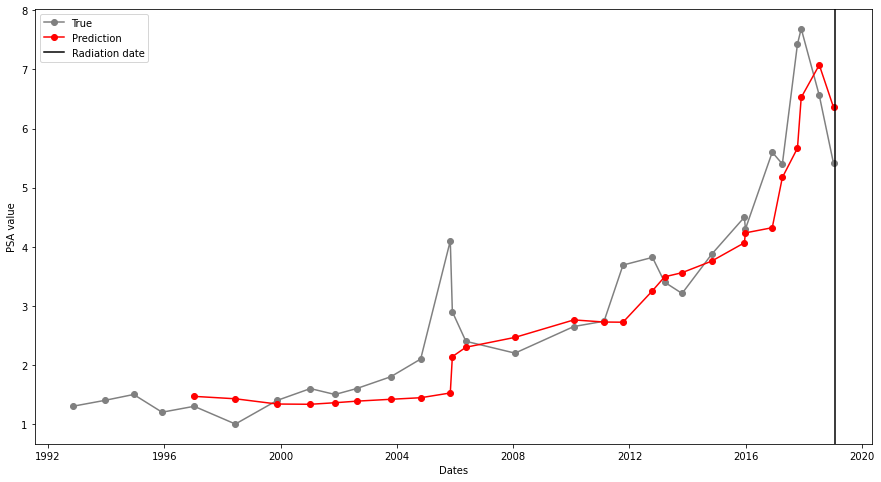

In [ ]:
patient = merged[merged['EMPI'] == 100021664].sort_values(by='time_lab_result')

patient.time_lab_result = pd.to_datetime(patient.time_lab_result).dt.date
patient.rdtdate_first = pd.to_datetime(patient.rdtdate_first).dt.date
#merged[(merged['EMPI'].isin(test_idx)) & (merged['rdtdate_first'] != '2040-12-15 00:00:00')].iloc[0:30, :]
plt.figure(figsize=(15, 8))
plt.plot(patient.time_lab_result, patient.PSA, color="grey", marker="o", label="True")
plt.plot(patient.time_lab_result[4::], y_preds_patient, color="red", marker="o", label="Prediction")
plt.axvline(x=patient.rdtdate_a first.iloc[0], ymin=0, ymax=7, color="black", label="Radiation date")
plt.xlabel("Dates")
plt.ylabel("PSA value")
plt.legend()

In [ ]:
X_patient, y_patient = window(patient, l=4, report=False, rate=False)

In [ ]:
X_patient = X_patient.iloc[:, 1:]
X_patient = np.expand_dims(X_patient, axis=2)

y_patient = np.array(y_patient)

In [ ]:
y_preds_patient = model.predict(X_patient)

# Bag of Words

In [ ]:
original = merged[merged["report"]!= "0"]
original = original.dropna(subset=['PSA'])
mri_patients = filter_length(original, 3)
X_train, y_train, X_test, y_test = random_split(mri_patients, split_ratio=0.9, l=3, report=True, rate=False)

corpus_train = get_notes(X_train)
corpus_test = get_notes(X_test)
vectorizer = CountVectorizer(max_features=10, ngram_range=(1,2), stop_words='english')
bow_train = vectorizer.fit_transform(corpus_train)
bow_train = pd.DataFrame.sparse.from_spmatrix(bow_train)
bow_test = vectorizer.transform(corpus_test)
bow_test = pd.DataFrame.sparse.from_spmatrix(bow_test)

nb = len(X_train.columns) - 1
X_train = X_train.drop(nb,axis=1)
X_test = X_test.drop(nb,axis=1)
X_train = pd.concat([X_train, bow_train], axis=1)
X_test = pd.concat([X_test, bow_test], axis=1)
X_train.columns = range(X_train.columns.size)
X_test.columns = range(X_test.columns.size)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train = X_train.iloc[:, 1:]
X_train = np.expand_dims(X_train, axis=2)

X_test = X_test.iloc[:, 1:]
X_test = np.expand_dims(X_test, axis=2)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
model = Sequential([
                    Conv1D(64, 3, strides=3, input_shape=(X_train.shape[1], 1), activation="relu", padding="same"),
                    Dropout(0.2),
                    Conv1D(32, 2, strides=1, activation="relu"),
                    Dropout(0.2),
                    MaxPooling1D(),
                    Flatten(),
                    Dense(50, activation="relu", use_bias=True),
                    Dropout(0.2),
                    Dense(1, activation="elu")
])

model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_69 (Conv1D)          (None, 7, 64)             256       
                                                                 
 dropout_12 (Dropout)        (None, 7, 64)             0         
                                                                 
 conv1d_70 (Conv1D)          (None, 6, 32)             4128      
                                                                 
 dropout_13 (Dropout)        (None, 6, 32)             0         
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 3, 32)            0         
 g1D)                                                            
                                                                 
 flatten_44 (Flatten)        (None, 96)                0         
                                                     

In [ ]:
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001), metrics=["MeanSquaredError"])
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


477/477 [==============================] - 3s 4ms/step - loss: 21.1522 - mean_squared_error: 21.1522 - val_loss: 10.3663 - val_mean_squared_error: 10.3663
Epoch 2/30
477/477 [==============================] - 2s 4ms/step - loss: 15.9446 - mean_squared_error: 15.9446 - val_loss: 8.5944 - val_mean_squared_error: 8.5944
Epoch 3/30
477/477 [==============================] - 2s 4ms/step - loss: 13.7760 - mean_squared_error: 13.7760 - val_loss: 6.4061 - val_mean_squared_error: 6.4061
Epoch 4/30
477/477 [==============================] - 2s 4ms/step - loss: 13.5183 - mean_squared_error: 13.5183 - val_loss: 6.3423 - val_mean_squared_error: 6.3423
Epoch 5/30
477/477 [==============================] - 2s 4ms/step - loss: 12.7373 - mean_squared_error: 12.7373 - val_loss: 5.9279 - val_mean_squared_error: 5.9279
Epoch 6/30
477/477 [==============================] - 2s 4ms/step - loss: 12.7614 - mean_squared_error: 12.7614 - val_loss: 5.9189 - val_mean_squared_error: 5.9189
Epoch 7/30
477/477 [=====

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: ", r2_score(y_pred, y_test))
print("MAPE: ", mean_absolute_percentage_error(y_pred, y_test))

RMSE: 4.27
R2:  -0.5544286759233725
MAPE:  0.3837088994818385


# Trying an LSTM approach for our time series data

In [ ]:
X_train_LSTM = np.array(X_train.iloc[:, 1:10])
y_train = np.array(y_train)

X_test_LSTM = np.array(X_test.iloc[:, 1:10])
y_test = np.array(y_test)

In [ ]:
X_train_LSTM = np.reshape(X_train_LSTM, (len(X_train), -1, 3))

X_test_LSTM = np.reshape(X_test_LSTM, (len(X_test), -1, 3))

In [ ]:
model = Sequential([
                    LSTM(30, activation="relu", input_shape=(3, 3), return_sequences=True),
                    LSTM(10, activation='relu'),
                    Dropout(0.2),
                    Dense(1, activation="relu"),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 30)             4080      
                                                                 
 lstm_5 (LSTM)               (None, 10)                1640      
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,731
Trainable params: 5,731
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001), metrics=["MeanSquaredError"])
model.fit(X_train_LSTM, y_train, epochs=30, batch_size=16, validation_split=0.1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


477/477 [==============================] - 9s 15ms/step - loss: 22.2890 - mean_squared_error: 22.2890 - val_loss: 7.1855 - val_mean_squared_error: 7.1855
Epoch 2/30
477/477 [==============================] - 7s 15ms/step - loss: 14.5164 - mean_squared_error: 14.5164 - val_loss: 5.8042 - val_mean_squared_error: 5.8042
Epoch 3/30
477/477 [==============================] - 7s 15ms/step - loss: 12.3859 - mean_squared_error: 12.3859 - val_loss: 5.3933 - val_mean_squared_error: 5.3933
Epoch 4/30
477/477 [==============================] - 7s 15ms/step - loss: 13.7610 - mean_squared_error: 13.7610 - val_loss: 5.7596 - val_mean_squared_error: 5.7596
Epoch 5/30
477/477 [==============================] - 8s 17ms/step - loss: 11.7473 - mean_squared_error: 11.7473 - val_loss: 5.0576 - val_mean_squared_error: 5.0576
Epoch 6/30
477/477 [==============================] - 7s 15ms/step - loss: 12.7895 - mean_squared_error: 12.7895 - val_loss: 5.5436 - val_mean_squared_error: 5.5436
Epoch 7/30
477/477 [=

In [ ]:
y_pred = model.predict(X_test_LSTM)
mse = mean_squared_error(y_pred, y_test)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: ", r2_score(y_pred, y_test))
print("MAPE: ", mean_absolute_percentage_error(y_pred, y_test))

RMSE: 3.75
R2:  0.5010613931829128
MAPE:  9029494302401.484


In [ ]:
np.max(y_pred-y_test)

29.88659484863281

# Joint Model - Separate heads for patient features and BoW

In [ ]:
l = 4
original = merged[merged["report"]!= "0"]
original = original.dropna(subset=['PSA'])
mri_patients = filter_length(original, l)
X_train, y_train, X_test, y_test = random_split(mri_patients, split_ratio=0.9, l=l, report=True, rate=False, comorb=True, race=True)

corpus_train = get_notes(X_train)
corpus_test = get_notes(X_test)
vectorizer = CountVectorizer(max_features=100, ngram_range=(1, 2), stop_words='english')
bow_train = vectorizer.fit_transform(corpus_train)
bow_train = pd.DataFrame.sparse.from_spmatrix(bow_train)
bow_test = vectorizer.transform(corpus_test)
bow_test = pd.DataFrame.sparse.from_spmatrix(bow_test)

nb = len(X_train.columns) - 1
X_train = X_train.drop(nb,axis=1)
X_test = X_test.drop(nb,axis=1)
X_train = pd.concat([X_train, bow_train], axis=1)
X_test = pd.concat([X_test, bow_test], axis=1)
X_train.columns = range(X_train.columns.size)
X_test.columns = range(X_test.columns.size)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

X_train = X_train.iloc[:, 1:]
#X_train = np.expand_dims(X_train, axis=2)

X_test = X_test.iloc[:, 1:]
#X_test = np.expand_dims(X_test, axis=2)

#X_train = np.array(X_train)
#y_train = np.array(y_train)

#X_test = np.array(X_test)
#y_test = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
X_train_time = X_train.iloc[:, 0:3*l+21]
X_train_meta = np.array(X_train.iloc[:, 3*l+21::])

X_test_time = X_test.iloc[:, 0:3*l+21]
X_test_meta = np.array(X_test.iloc[:, 3*l+21::])

#X_train_time = np.reshape(np.array(X_train_time), (len(X_train), -1, 3))

#X_test_time = np.reshape(np.array(X_test_time), (len(X_test), -1, 3))

X_train_time = np.array(X_train_time)
X_test_time = np.array(X_test_time)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train_time = np.expand_dims(X_train_time, axis=2)
X_test_time = np.expand_dims(X_test_time, axis=2)

In [ ]:
input_time = Input(shape=(X_train_time.shape[1], 1))

#x = LSTM(50, activation="relu", input_shape=(l, 3), return_sequences=False)(input_time)
#x = BatchNormalization(axis=-1)(x)
#x = Dropout(0.3)(x)
#x = LSTM(20, activation="relu")(x)

x = Conv1D(32, 3, strides=3, activation="relu", padding="same")(input_time)
#x = Dropout(0.2)(x)
x = Conv1D(64, 3, strides=1, activation="relu")(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, strides=1, activation="relu")(x)
#x = AveragePooling1D(x)
x = Flatten()(x)
x = Dense(30, activation="relu", kernel_regularizer=L1(1e-4))(x)
x = Dense(10, activation="relu", kernel_regularizer=L1(1e-4))(x)
#x = Dense(1, activation="relu")(x)

x = Model(inputs=input_time, outputs = x)

input_bow = Input(shape = (X_train_meta.shape[1]))

#y = Dense(128, activation="relu")(input_bow)
#y = Dropout(0.3)(y)
y = Dense(32, activation="relu", kernel_regularizer=L1(1e-4))(input_bow)
y = BatchNormalization(axis=-1)(y)
y = Dense(16, activation="relu", kernel_regularizer=L1(1e-4))(y)
y = Dense(8, activation="relu")(y)
y = Model(inputs=input_bow, outputs = y)

concatenated = concatenate([x.output, y.output])

z = Dense(10, activation="relu")(concatenated)
z = Dense(1, activation="linear")(z)
model = Model(inputs=[x.input, y.input], outputs=z)

model.summary()
# BatchNormalization

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d_220 (Conv1D)            (None, 11, 32)       128         ['input_14[0][0]']               
                                                                                                  
 conv1d_221 (Conv1D)            (None, 9, 64)        6208        ['conv1d_220[0][0]']             
                                                                                                  
 input_15 (InputLayer)          [(None, 110)]        0           []                               
                                                                                           

In [ ]:
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001), metrics=["MeanSquaredError"])
history = model.fit([X_train_time, X_train_meta], y_train, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


477/477 [==============================] - 4s 7ms/step - loss: 18.9832 - mean_squared_error: 18.9088 - val_loss: 5.9469 - val_mean_squared_error: 5.8785
Epoch 2/10
477/477 [==============================] - 3s 6ms/step - loss: 11.3060 - mean_squared_error: 11.2397 - val_loss: 8.1452 - val_mean_squared_error: 8.0810
Epoch 3/10
477/477 [==============================] - 3s 6ms/step - loss: 10.3649 - mean_squared_error: 10.3022 - val_loss: 5.3942 - val_mean_squared_error: 5.3326
Epoch 4/10
477/477 [==============================] - 3s 6ms/step - loss: 10.6811 - mean_squared_error: 10.6208 - val_loss: 5.4090 - val_mean_squared_error: 5.3505
Epoch 5/10
477/477 [==============================] - 3s 6ms/step - loss: 9.6558 - mean_squared_error: 9.5988 - val_loss: 5.2620 - val_mean_squared_error: 5.2066
Epoch 6/10
477/477 [==============================] - 3s 6ms/step - loss: 10.7679 - mean_squared_error: 10.7138 - val_loss: 5.4432 - val_mean_squared_error: 5.3901
Epoch 7/10
477/477 [=========

In [ ]:
y_pred = model.predict([X_test_time, X_test_meta])
mse = mean_squared_error(y_pred, y_test)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: ", r2_score(y_pred, y_test))
print("MAPE: ", mean_absolute_percentage_error(y_pred, y_test))

RMSE: 3.80
R2:  0.355253226787999
MAPE:  0.2738781025077393
